In [53]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt

In [54]:
# Load Data
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [55]:
# Get basic dataset statistics
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [56]:
# Check for missing values
missing_cols = df.columns[df.isnull().any()]

# Display columns with missing values and the count of missing values in each
missing_info = df[missing_cols].isnull().sum()
print(missing_info)

Age         177
Cabin       687
Embarked      2
dtype: int64


In [57]:
# Fill missing values in the 'Age' column of the training set with the median age
df['Age'].fillna(df['Age'].median(), inplace=True)

# Fill missing values in the 'Embarked' column of the training set with the most common embarkation port (mode)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# Fill missing values in the 'Age' column of the test set with the median age
df_test['Age'].fillna(df_test['Age'].median(), inplace=True)

# Fill missing values in the 'Embarked' column of the test set with the most common embarkation port (mode)
df_test['Embarked'].fillna(df_test['Embarked'].mode()[0], inplace=True)

C:\Users\mattias.hoehnen\AppData\Local\Temp\ipykernel_22496\1966836829.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
C:\Users\mattias.hoehnen\AppData\Local\Temp\ipykernel_22496\1966836829.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

In [58]:
# Create a new feature 'Fam Size' representing the total number of family members (parents/children + siblings/spouses + self) for the training set
df['Fam Size'] = df['Parch'] + df['SibSp'] + 1

# Create a boolean feature 'Is Alone' which is True if the passenger is traveling alone (family size less than 2) in the training set
df['Is Alone'] = df['Fam Size'] < 2

# Repeat the same feature engineering for the test set
df_test['Fam Size'] = df_test['Parch'] + df_test['SibSp'] + 1
df_test['Is Alone'] = df_test['Fam Size'] < 2

In [59]:
# Avg Fare
df['Avg Fare'] = df['Fare'] / df['Fam Size']
df_test['Avg Fare'] = df_test['Fare'] / df_test['Fam Size']


# Age Class
df['Age Class'] = df['Age'] * df['Pclass']
df_test['Age Class'] = df_test['Age'] * df_test['Pclass']

# Age Fare
df['Age Fare'] = df['Age'] * df['Fare']
df_test['Age Fare'] = df_test['Age'] * df_test['Fare']

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fam Size,Is Alone,Avg Fare,Age Class,Age Fare
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,False,3.62500,66.0,159.5000
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,False,35.64165,38.0,2708.7654
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,True,7.92500,78.0,206.0500
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,False,26.55000,35.0,1858.5000
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,True,8.05000,105.0,281.7500


In [60]:
# create a new feature to extract title names from the Name column
df['Title'] = df.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())
df_test['Title'] = df_test.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())
# normalize the titles
normalized_titles = {
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "the Countess":"Royalty",
    "Dona":       "Royalty",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royalty"
}
# map the normalized titles to the current titles 
df.Title = df.Title.map(normalized_titles)
df_test.Title = df_test.Title.map(normalized_titles)

# view value counts for the normalized titles
print(df.Title.value_counts())

df.head()

Title
Mr         517
Miss       184
Mrs        127
Master      40
Officer     18
Royalty      5
Name: count, dtype: int64


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fam Size,Is Alone,Avg Fare,Age Class,Age Fare,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,False,3.62500,66.0,159.5000,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,False,35.64165,38.0,2708.7654,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,True,7.92500,78.0,206.0500,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,False,26.55000,35.0,1858.5000,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,True,8.05000,105.0,281.7500,Mr


In [63]:
# Import the MinMaxScaler for normalization
# (Make sure you have: from sklearn.preprocessing import MinMaxScaler somewhere above)

# Initialize the MinMaxScaler to scale features to the [0, 1] range
scaler = MinMaxScaler()

# Normalize selected numerical features in the training set
df[['Age', 'SibSp', 'Parch', 'Fare', 'Fam Size', 'Avg Fare', 'Age Class', 'Age Fare']] = scaler.fit_transform(
    df[['Age', 'SibSp', 'Parch', 'Fare', 'Fam Size', 'Avg Fare', 'Age Class', 'Age Fare']]
)
df.head()  # Display the first few rows to inspect the normalized values

# Normalize the same features in the test set using the scaler fitted on the training set
df_test[['Age', 'SibSp', 'Parch', 'Fare', 'Fam Size', 'Avg Fare', 'Age Class', 'Age Fare']] = scaler.transform(
    df_test[['Age', 'SibSp', 'Parch', 'Fare', 'Fam Size', 'Avg Fare', 'Age Class', 'Age Fare']]
)

In [64]:
# Convert the 'Sex' column to numerical values: 0 for male, 1 for female in the training set
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

# Convert categorical variables 'Pclass', 'Embarked', and 'Title' into one-hot encoded (dummy) variables in the training set
df = pd.get_dummies(df, columns=['Pclass', 'Embarked', 'Title'])

# Display the first few rows to inspect the changes
df.head()

# Repeat the same encoding for the test set
df_test['Sex'] = df_test['Sex'].map({'male': 0, 'female': 1})
df_test = pd.get_dummies(df_test, columns=['Pclass', 'Embarked', 'Title'])

In [66]:
# (Optional) Save the PassengerId column from the training set if needed for later use (currently commented out)
# passenger_id = df['PassengerId']

# Drop columns that are not useful for prediction from the training set
# 'PassengerId', 'Name', 'Ticket', and 'Cabin' are removed as they are either identifiers or contain too many missing values
df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)
df.head()  # Display the first few rows to inspect the changes

# Save the PassengerId column from the test set for use in the submission file
passenger_id_test = df_test['PassengerId']

# Drop the same unnecessary columns from the test set
df_test.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)

In [67]:
# Separate the features (X) and the target variable (y) from the training set
X = df.drop(columns='Survived')  # Features: all columns except 'Survived'
y = df['Survived']               # Target: the 'Survived' column

# Split the data into training and validation sets
# 80% for training, 20% for validation, using a fixed random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
# Check for null values
X.isnull().sum()

Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Fam Size         0
Is Alone         0
Avg Fare         0
Age Class        0
Age Fare         0
Pclass_1         0
Pclass_2         0
Pclass_3         0
Embarked_C       0
Embarked_Q       0
Embarked_S       0
Title_Master     0
Title_Miss       0
Title_Mr         0
Title_Mrs        0
Title_Officer    0
Title_Royalty    0
dtype: int64

In [69]:
# Define the hyperparameters for the XGBoost classifier
params = {
    'objective': 'binary:logistic',  # Binary classification (survived or not)
    'learning_rate': 0.1,            # Step size shrinkage used in update to prevent overfitting
    'max_depth': 6,                  # Maximum depth of a tree
    'min_child_weight': 1,           # Minimum sum of instance weight (hessian) needed in a child
    'subsample': 0.8,                # Subsample ratio of the training instances
    'colsample_bytree': 0.8,         # Subsample ratio of columns when constructing each tree
    'n_estimators': 100,             # Number of boosting rounds (trees)
    'verbosity': 1                   # Controls the amount of messages printed
}

# Initialize the XGBoost classifier with the specified parameters
model = xgb.XGBClassifier(**params)

# Train the model on the training data, and evaluate on the validation set
# 'eval_set' allows monitoring performance on the validation set during training
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

[0]	validation_0-logloss:0.63546
[1]	validation_0-logloss:0.59646
[2]	validation_0-logloss:0.56314
[3]	validation_0-logloss:0.53665
[4]	validation_0-logloss:0.51670
[5]	validation_0-logloss:0.49885
[6]	validation_0-logloss:0.48418


[7]	validation_0-logloss:0.47060
[8]	validation_0-logloss:0.45737
[9]	validation_0-logloss:0.44775
[10]	validation_0-logloss:0.43978
[11]	validation_0-logloss:0.43182
[12]	validation_0-logloss:0.42580
[13]	validation_0-logloss:0.41937
[14]	validation_0-logloss:0.41542
[15]	validation_0-logloss:0.40846
[16]	validation_0-logloss:0.40378
[17]	validation_0-logloss:0.40217
[18]	validation_0-logloss:0.39938
[19]	validation_0-logloss:0.39713
[20]	validation_0-logloss:0.39414
[21]	validation_0-logloss:0.39176
[22]	validation_0-logloss:0.39026
[23]	validation_0-logloss:0.38840
[24]	validation_0-logloss:0.39039
[25]	validation_0-logloss:0.38790
[26]	validation_0-logloss:0.38494
[27]	validation_0-logloss:0.38727
[28]	validation_0-logloss:0.38773
[29]	validation_0-logloss:0.38825
[30]	validation_0-logloss:0.38796
[31]	validation_0-logloss:0.38808
[32]	validation_0-logloss:0.38740
[33]	validation_0-logloss:0.38771
[34]	validation_0-logloss:0.38615
[35]	validation_0-logloss:0.38571
[36]	validation_0

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [70]:
# Initialize a Random Forest classifier with 100 trees
random_forest = RandomForestClassifier(n_estimators=100)

# Train the Random Forest model on the training data
random_forest.fit(X_train, y_train)

# Predict the target values for the validation set
random_forest_y_pred = random_forest.predict(X_test)

# Calculate and return the accuracy of the model on the training set
random_forest.score(X_train, y_train)

0.9817415730337079

In [22]:
# Use the trained model to predict survival on the validation set
y_pred = model.predict(X_test)

# Calculate the accuracy of the model on the validation set
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy as a percentage
print(f"Accuracy is: {accuracy}%")

# Print a detailed classification report including precision, recall, f1-score, and support for each class
print(classification_report(y_test, y_pred))

Accuracy is: 0.8156424581005587%
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       105
           1       0.78      0.77      0.78        74

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



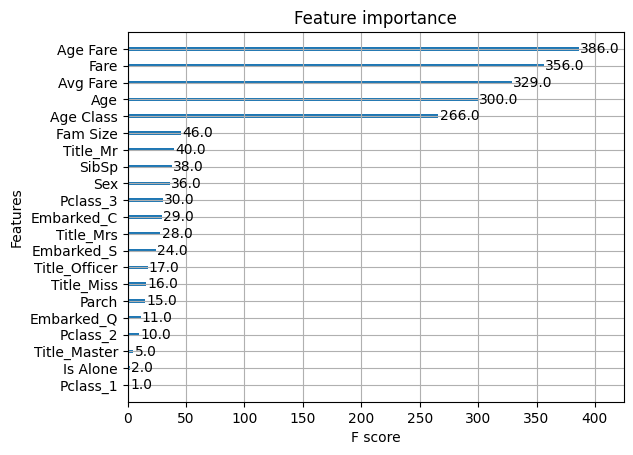

In [24]:
# Plot the feature importances as determined by the trained XGBoost model
xgb.plot_importance(model)

# Display the plot
plt.show()

In [ ]:
# Check for missing values in each column of the DataFrame 'X_full'
# This will display the count of null (NaN) values for each feature
X_full.isnull().sum()

In [48]:
# Instantiate a new XGBoost classifier with the previously defined parameters
model_grid = xgb.XGBClassifier(**params)

# Define the hyperparameter grid to search over for tuning the model
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],      # Different learning rates to try
    'max_depth': [4, 6, 8],                      # Different tree depths
    'min_child_weight': [1, 5, 10, 12, 14],      # Different minimum child weights
    'subsample': [0.4, 0.8],                     # Different subsample ratios
    'n_estimators': [50, 100, 200, 250]          # Different numbers of trees
}

# Set up grid search with 3-fold cross-validation to find the best hyperparameters
grid_search = GridSearchCV(
    estimator=model_grid,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=True
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, ma...
                                     max_leaves=None, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=100,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.3],
                         'max_depth': [4, 6, 8],
                         'min_child_weight': [1, 5, 10, 12, 14],
                         'n_estimators': [50, 100, 200, 250],
                         'subsample': [0.4, 0.8]},
             scoring='accuracy', verbose=True)

In [49]:
# Print the best hyperparameters found during grid search
print(f"Best Parameters {grid_search.best_params_}")

# Print the best cross-validated accuracy score achieved during grid search
print(f"Best Performance: {grid_search.best_score_}")

Best Parameters {'learning_rate': 0.2, 'max_depth': 4, 'min_child_weight': 12, 'n_estimators': 200, 'subsample': 0.8}
Best Performance: 0.8469429966079258


In [50]:
# Use the best model found by grid search to predict survival on the validation set
y_pred = grid_search.predict(X_test)

# Calculate the accuracy of the best model on the validation set
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy as a percentage
print(f"Accuracy is: {accuracy}%")

# Print a detailed classification report for the best model, including precision, recall, f1-score, and support for each class
print(classification_report(y_test, y_pred))

Accuracy is: 0.8268156424581006%
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       105
           1       0.80      0.77      0.79        74

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



In [71]:
# Use the trained Random Forest model to predict survival on the test set
predictions = random_forest.predict(df_test)

# Display the predictions (0 = did not survive, 1 = survived)
predictions

array([0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [72]:
# Create a DataFrame for the Kaggle submission file
# The submission must contain 'PassengerId' and the predicted 'Survived' values
submission = pd.DataFrame({
    'PassengerId': passenger_id_test,
    'Survived': predictions
})

# Save the submission DataFrame to a CSV file in the required format (no index column)
submission.to_csv('submission.csv', index=False)